# SPGL1 demo

This notebook contains a Python implementation of the original examples from SPGL1 MATLAB solver 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import spdiags
from scipy.sparse.linalg import lsqr as splsqr
from spgl1.lsqr import lsqr
from spgl1 import spgl1, spg_lasso, spg_bp, spg_bpdn, spg_mmv
from spgl1.spgl1 import norm_l1nn_primal, norm_l1nn_dual, norm_l1nn_project
from spgl1.spgl1 import norm_l12nn_primal, norm_l12nn_dual, norm_l12nn_project

# Initialize random number generators
np.random.seed(43273289)

## Lasso

In [2]:
# Create random m-by-n encoding matrix and sparse vector
m = 50
n = 128
k = 14
[A,Rtmp] = np.linalg.qr(np.random.randn(n,m),'reduced')
A  = A.T
p  = np.random.permutation(n)
p = p[0:k]
x0 = np.zeros(n)
x0[p] = np.random.randn(k)

Solve the underdetermined LASSO problem for $||x||_1 <= \pi$:

$$min.||Ax-b||_2 \quad subject \quad  to \quad ||x||_1 <= \pi$$

In [3]:
b = A.dot(x0)
tau = np.pi
x,resid,grad,info = spg_lasso(A, b, tau, verbosity=1)

print()
print('%s%s%s' % ('-'*35,' Solution ','-'*35))
print('nonzeros(x) = %i,   ||x||_1 = %12.6e,   ||x||_1 - pi = %13.6e' % \
        (np.sum(abs(x)>1e-5), np.linalg.norm(x,1), np.linalg.norm(x,1)-np.pi))
print('%s' % ('-'*80))


SPGL1
No. rows              :       50     
No. columns           :      128

Initial tau           : 3.14e+00     
Two-norm of b         : 3.40e+00

Optimality tol        : 1.00e-04     
Target one-norm of x  : 3.14e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      500


EXIT -- Optimal solution found

Products with A     :       8        Total time   (secs) :     0.0
Products with A^H   :       8        Project time (secs) :     0.0
Newton iterations   :       0        Mat-vec time (secs) :     0.0
Line search its     :       0        Subspace iterations :       0

----------------------------------- Solution -----------------------------------
nonzeros(x) = 7,   ||x||_1 = 3.141593e+00,   ||x||_1 - pi =  8.881784e-16
--------------------------------------------------------------------------------


## BP

Solve the basis pursuit (BP) problem:

$$min.  ||x||_1 \quad subject \quad  to \quad  Ax = b$$


SPGL1
No. rows              :       50     
No. columns           :      128

Initial tau           : 0.00e+00     
Two-norm of b         : 3.40e+00

Optimality tol        : 1.00e-04     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      500

iterr      Objective   Relative Gap  Rel Error      gnorm   stepg   nnz_x   nnz_g     tau

    0  3.3978494e+00  0.0000000e+00   1.00e+00  8.995e-01     0.0       0       0  1.2834830e+01
    1  1.4610032e+00  1.6532743e+00   1.00e+00  3.459e-01    -0.6      67       1               
    2  1.2957367e+00  1.4480527e+00   1.00e+00  3.057e-01     0.0      53       1               
    3  1.0445582e+00  1.0186987e+00   1.00e+00  2.394e-01     0.0      33       1               
    4  9.8320803e-01  1.9671347e+00   9.83e-01  3.006e-01     0.0      17       1               
    5  1.0408537e+00  2.7237524e+00   1.00e+00  3.273e-01     0.0      15       1               
    6  8.3766484e-01  4.4627639e

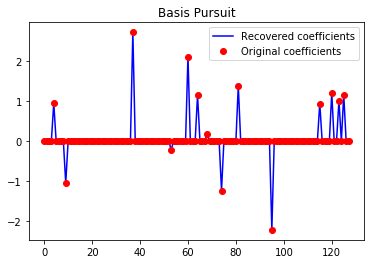

In [4]:
b = A.dot(x0) # signal
x,resid,grad,info = spg_bp(A, b, verbosity=2)

plt.figure()
plt.plot(x,'b')
plt.plot(x0,'ro')
plt.legend(('Recovered coefficients','Original coefficients'))
plt.title('Basis Pursuit');

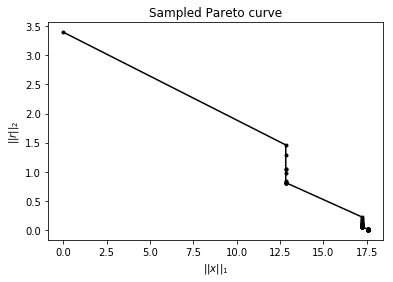

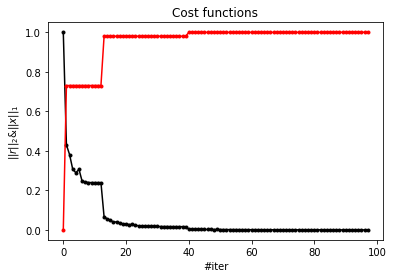

In [5]:
plt.figure()
plt.plot(info['xnorm1'], info['rnorm2'], '.-k')
plt.xlabel(r'$||x||_1$')
plt.ylabel(r'$||r||_2$')
plt.title('Sampled Pareto curve')

plt.figure()
plt.plot(np.arange(info['niters']), info['rnorm2']/max(info['rnorm2']), '.-k')
plt.plot(np.arange(info['niters']), info['xnorm1']/max(info['xnorm1']), '.-r')
plt.xlabel(r'#iter')
plt.ylabel(r'$||r||_2 & ||x||_1$');
plt.title('Cost functions');

## BPDN

Solve the basis pursuit denoise (BPDN) problem:

$$min. ||x||_1 \quad subject \quad to \quad ||Ax - b||_2 <= 0.1$$


SPGL1
No. rows              :       50     
No. columns           :      128

Initial tau           : 0.00e+00     
Two-norm of b         : 3.49e+00

Optimality tol        : 1.00e-04     
Target objective      : 1.00e-01

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :       10

iterr      Objective   Relative Gap  Rel Error      gnorm   stepg   nnz_x   nnz_g     tau

    0  3.4876525e+00  0.0000000e+00   9.71e-01  8.998e-01     0.0       0       0  1.3130733e+01
    1  1.5278506e+00  1.5445083e+00   9.35e-01  3.512e-01    -0.6      70       1               
    2  1.3785367e+00  1.3210423e+00   9.27e-01  3.004e-01     0.0      48       1               
    3  1.1435885e+00  1.0754951e+00   9.13e-01  2.436e-01     0.0      36       1               
    4  1.0650070e+00  1.8808347e+00   9.06e-01  3.058e-01     0.0      24       1               
    5  1.1055544e+00  1.9676460e+00   9.10e-01  2.609e-01     0.0      14       1               
    6  9.7104698e-01  5.0757852e

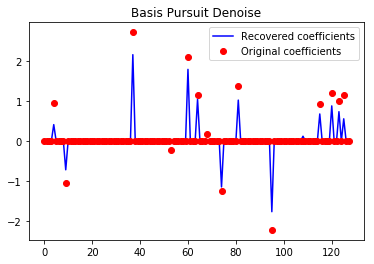

In [6]:
b = A.dot(x0) + np.random.randn(m) * 0.075
sigma = 0.10  #     % Desired ||Ax - b||_2
x,resid,grad,info = spg_bpdn(A, b, sigma, iter_lim=10, verbosity=2)

plt.figure()
plt.plot(x,'b')
plt.plot(x0,'ro')
plt.legend(('Recovered coefficients','Original coefficients'))
plt.title('Basis Pursuit Denoise');

## BPDN with non-negative solution

We repeat the same procedure but we have only positive elements in the x vector. We compare spgl1 with L1 norms and with L1NN norms


SPGL1
No. rows              :       50     
No. columns           :      128

Initial tau           : 0.00e+00     
Two-norm of b         : 1.45e+00

Optimality tol        : 1.00e-04     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :       20


ERROR EXIT -- Too many iterations

Products with A     :      24        Total time   (secs) :     0.0
Products with A^H   :      21        Project time (secs) :     0.0
Newton iterations   :       2        Mat-vec time (secs) :     0.0
Line search its     :       3        Subspace iterations :       0

SPGL1
No. rows              :       50     
No. columns           :      128

Initial tau           : 0.00e+00     
Two-norm of b         : 1.45e+00

Optimality tol        : 1.00e-04     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :       20


ERROR EXIT -- Too many iterations

Products with A     :      24        Total time   (secs) :     0.0
Pro

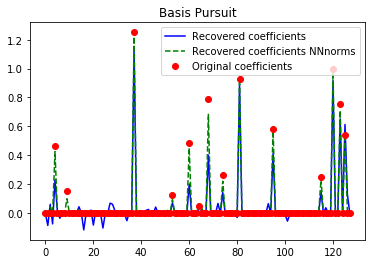

In [7]:
x0 = np.zeros(n)
x0[p] = np.abs(np.random.randn(k))
b = A.dot(x0) # signal

x,resid,grad,info = spg_bp(A, b, iter_lim=20, verbosity=1)


xnn,residnn,gradnn,infonn = spg_bp(A, b, iter_lim=20, verbosity=1, 
                                   project=norm_l1nn_project, 
                                   primal_norm=norm_l1nn_primal,
                                   dual_norm=norm_l1nn_dual)

plt.figure()
plt.plot(x,'b')
plt.plot(xnn,'--g')
plt.plot(x0,'ro')
plt.legend(('Recovered coefficients', 'Recovered coefficients NNnorms','Original coefficients'))
plt.title('Basis Pursuit');

## BP with complex numbers

Solve the basis pursuit (BP) problem in COMPLEX variables:

$$min. ||z||_1 \quad subject \quad to \quad  Az = b$$


SPGL1
No. rows              :       50     
No. columns           :      128

Initial tau           : 0.00e+00     
Two-norm of b         : 2.78e+00

Optimality tol        : 1.00e-04     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      500

iterr      Objective   Relative Gap  Rel Error      gnorm   stepg   nnz_x   nnz_g     tau

    0  2.7830815e+00  0.0000000e+00   1.00e+00  7.891e-01     0.0       0       0  9.8155346e+00
    1  1.4897141e+00  1.7264979e+00   1.00e+00  3.852e-01    -0.6      91       0               
    2  1.3104225e+00  1.1222827e+00   1.00e+00  2.978e-01     0.0      62       0               
    3  1.1126604e+00  6.4597283e-01   1.00e+00  2.023e-01     0.0      28       0               
    4  1.0695040e+00  8.0305624e-01   1.00e+00  2.541e-01     0.0      27       0               
    5  1.0417686e+00  5.7568961e-01   1.00e+00  1.964e-01     0.0      18       0               
    6  1.0237323e+00  7.8159888e

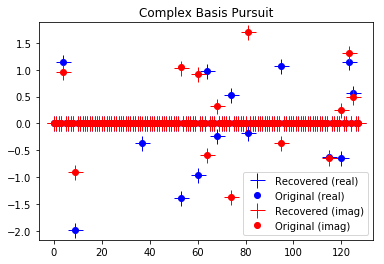

In [8]:
from scipy.sparse.linalg import LinearOperator

class partialFourier(LinearOperator):
    def __init__(self, idx, n):
        self.idx = idx
        self.n = n
        self.shape = (len(idx), n)
        self.dtype = np.complex128
    def _matvec(self, x): 
        # % y = P(idx) * FFT(x)
        z = np.fft.fft(x) / np.sqrt(n)
        return z[idx]
    def _rmatvec(self, x): 
        z = np.zeros(n,dtype=complex)
        z[idx] = x
        return np.fft.ifft(z) * np.sqrt(n)

    
# % Create partial Fourier operator with rows idx
idx = np.random.permutation(n)
idx = idx[0:m]
opA = partialFourier(idx, n)

# % Create sparse coefficients and b = 'A' * z0;
z0 = np.zeros(n,dtype=complex)
z0[p] = np.random.randn(k) + 1j * np.random.randn(k)
b = opA.matvec(z0)

z,resid,grad,info = spg_bp(opA,b, verbosity=2)

plt.figure()
plt.plot(z.real,'b+',markersize=15.0)
plt.plot(z0.real,'bo')
plt.plot(z.imag,'r+',markersize=15.0)
plt.plot(z0.imag,'ro')
plt.legend(('Recovered (real)', 'Original (real)', 'Recovered (imag)', 'Original (imag)'))
plt.title('Complex Basis Pursuit');

## Pareto Frontier

Sample the Pareto frontier at 100 points:
  
$$phi(tau) = min. ||Ax-b||_2 \quad subject \quad to \quad ||x|| <= \tau$$

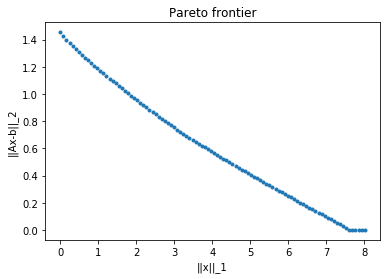

In [9]:
b = A.dot(x0)
x = np.zeros(n)
tau = np.linspace(0, 1.05 * np.linalg.norm(x0, 1), 100)
tau[0] = 1e-10
phi = np.zeros(tau.size)

for i in range(tau.size):
    x,r,grad,info = spgl1(A, b, tau[i], 0, x, iter_lim=1000)
    phi[i] = np.linalg.norm(r)

plt.figure()
plt.plot(tau,phi, '.')
plt.title('Pareto frontier')
plt.xlabel('||x||_1')
plt.ylabel('||Ax-b||_2');

## Weighted BP

Solve

$$min. ||y||_1 \quad subject \quad  to \quad AW^{-1}y = b$$

and the weighted basis pursuit (BP) problem:

$$min. ||Wx||_1 \quad subject \quad to \quad Ax = b$$

followed by setting $y = Wx$.

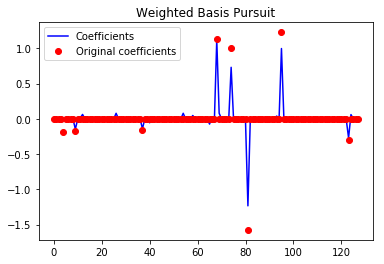

In [10]:
# Sparsify vector x0 a bit more to get exact recovery
k = 9
x0 = np.zeros(n)
x0[p[0:k]] = np.random.randn(k)

# Set up weights w and vector b
w = np.random.rand(n) + 0.1 # Weights
b = A.dot(x0/w) # Signal

# Solution
x,resid,grad,info = spg_bp(A, b, **dict(iter_lim=1000, weights=w))

# Reconstructed solution, with weighting
x1 = x * w

plt.figure()
plt.plot(x1,'b')
plt.plot(x0,'ro')
plt.legend(('Coefficients','Original coefficients'))
plt.title('Weighted Basis Pursuit');

## MMV

Solve the multiple measurement vector (MMV) problem

$$(1) \quad min. ||Y||_{1,2}  \quad subject \quad to \quad  AW^{-1}Y = B$$

and the weighted MMV problem (weights on the rows of X):

$$(2) \quad min. ||WX||_{1,2} \quad subject \quad to \quad AX = B$$

followed by setting $Y = WX$.


SPGL1
No. rows              :      600     
No. columns           :      900

Initial tau           : 0.00e+00     
Two-norm of b         : 1.39e+02

Optimality tol        : 1.00e-04     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :     6000



Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1



EXIT -- Found a BP solution

Products with A     :    7205        Total time   (secs) :     9.4
Products with A^H   :    3762        Project time (secs) :     5.9
Newton iterations   :      44        Mat-vec time (secs) :     0.3
Line search its     :    3431        Subspace iterations :       0

SPGL1
No. rows              :      600     
No. columns           :      900

Initial tau           : 0.00e+00     
Two-norm of b         : 1.39e+02

Optimality tol        : 1.00e-04     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :     6000

iterr      Objective   Relative Gap  Rel Error      gnorm   stepg   nnz_x   nnz_g     tau

    0  1.3889379e+02  0.0000000e+00   1.00e+00  5.510e+03     0.0       0       0  3.5012369e+00
    1  1.0633151e+02  1.8286125e+00   1.00e+00  3.904e+03    -0.6     254       0               
    2  6.1884091e+01  6.9644415e-01   1.00e+00  1.352e+03     0.0      90       0               
    3  5.0592369e+01  1.9

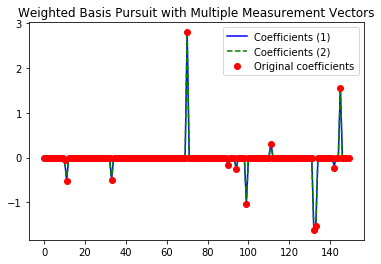

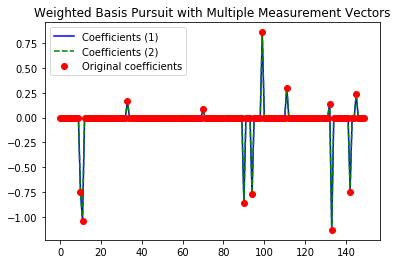

In [11]:
# Create problem
m = 100
n = 150
k = 12
l = 6;
A = np.random.randn(m, n)
p = np.random.permutation(n)[:k]
X0 = np.zeros((n, l))
X0[p, :] = np.random.randn(k, l)

weights = 3 * np.random.rand(n) + 0.1
W = 1/weights * np.eye(n)

B = A.dot(W).dot(X0)

# Solve unweighted version
x_uw, _, _, _ = spg_mmv(A.dot(W), B, 0, **dict(verbosity=1))

# Solve weighted version
x_w, _, _, _ = spg_mmv(A, B, 0, **dict(verbosity=2, weights=weights))
x_w = spdiags(weights, 0, n, n).dot(x_w)

# Plot results
plt.figure()
plt.plot(x_uw[:, 0], 'b-', label='Coefficients (1)')
plt.plot(x_w[:, 0], 'g--', label='Coefficients (2)')
plt.plot(X0[:, 0], 'ro', label='Original coefficients')
plt.legend()
plt.title('Weighted Basis Pursuit with Multiple Measurement Vectors');

plt.figure()
plt.plot(x_uw[:, 1], 'b', label='Coefficients (1)')
plt.plot(x_w[:, 1], 'g--', label='Coefficients (2)')
plt.plot(X0[:, 1], 'ro', label='Original coefficients')
plt.legend()
plt.title('Weighted Basis Pursuit with Multiple Measurement Vectors');

## MMV with non-negative solution


SPGL1
No. rows              :      600     
No. columns           :      900

Initial tau           : 0.00e+00     
Two-norm of b         : 8.07e+01

Optimality tol        : 1.00e-04     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :       10


ERROR EXIT -- Too many iterations

Products with A     :      13        Total time   (secs) :     0.0
Products with A^H   :      11        Project time (secs) :     0.0
Newton iterations   :       2        Mat-vec time (secs) :     0.0
Line search its     :       2        Subspace iterations :       0

SPGL1
No. rows              :      600     
No. columns           :      900

Initial tau           : 0.00e+00     
Two-norm of b         : 8.07e+01

Optimality tol        : 1.00e-04     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :       10


ERROR EXIT -- Too many iterations

Products with A     :      13        Total time   (secs) :     0.0
Pro

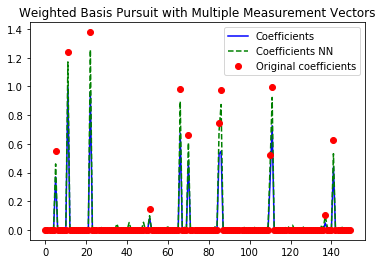

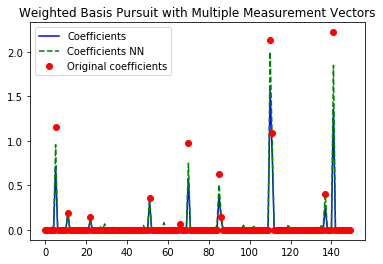

In [12]:
# Create problem
m = 100
n = 150
k = 12
l = 6;
A = np.random.randn(m, n)
p = np.random.permutation(n)[:k]
X0 = np.zeros((n, l))
X0[p, :] = np.abs(np.random.randn(k, l))

B = A.dot(X0)

X, _, _, _ = spg_mmv(A, B, 0, iter_lim=10, verbosity=1)
XNN, _, _, _ = spg_mmv(A, B, 0, iter_lim=10, verbosity=1,
                       project=norm_l12nn_project, 
                       primal_norm=norm_l12nn_primal, 
                       dual_norm=norm_l12nn_dual)
print('Negative X:', np.any(X))
print('Negative XNN:', np.any(XNN))


# Plot results
plt.figure()
plt.plot(X[:, 0], 'b-', label='Coefficients')
plt.plot(XNN[:, 0], 'g--', label='Coefficients NN')
plt.plot(X0[:, 0], 'ro', label='Original coefficients')
plt.legend()
plt.title('Weighted Basis Pursuit with Multiple Measurement Vectors');

plt.figure()
plt.plot(X[:, 1], 'b', label='Coefficients')
plt.plot(XNN[:, 1], 'g--', label='Coefficients NN')
plt.plot(X0[:, 1], 'ro', label='Original coefficients')
plt.legend()
plt.title('Weighted Basis Pursuit with Multiple Measurement Vectors');

## LSQR

Let's finally try to compare the internal lsqr with scipy lsqr and perform sgpl1 with subspace minimization

In [13]:
def Aprodfun(A, x, mode):
    if mode == 1:
        y = np.dot(A,x)
    else:
        return np.dot(np.conj(A.T), x)
    return y

 
LSQR            Least-squares solution of  Ax = b
The matrix A has       20 rows  and       10 cols
damp = 1.00000000000000e-05    wantvar =        1
atol = 1.00e-05                 conlim = 1.00e+12
btol = 1.00e-05                 itnlim =      100
 
   Itn      x(1)       r1norm     r2norm  Compatible   LS      Norm A   Cond A
     0  0.00000e+00  8.439e+00  8.439e+00   1.0e+00  4.5e-01
     1  4.29387e-01  4.857e+00  4.857e+00   5.8e-01  3.8e-01  4.6e+00  1.0e+00
     2  9.26782e-01  3.020e+00  3.020e+00   3.6e-01  3.8e-01  5.8e+00  2.4e+00
     3  1.06774e+00  1.992e+00  1.992e+00   2.4e-01  1.9e-01  8.6e+00  4.2e+00
     4  1.09945e+00  9.175e-01  9.175e-01   1.1e-01  9.4e-02  9.6e+00  5.8e+00
     5  9.92975e-01  4.452e-01  4.452e-01   5.3e-02  4.4e-02  1.0e+01  7.1e+00
     6  1.01319e+00  1.885e-01  1.885e-01   2.2e-02  1.3e-02  1.1e+01  8.4e+00
     7  1.01872e+00  1.020e-01  1.020e-01   1.2e-02  1.1e-02  1.1e+01  9.8e+00
     8  1.01012e+00  4.644e-02  4.644e-02   5.5e-03  

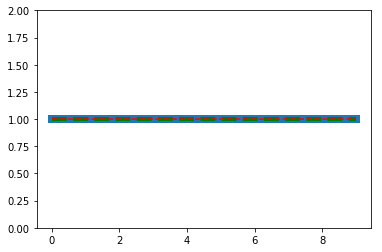

In [14]:
n = 10
m = 20
A = np.random.normal(0, 1, (m, n))
Aprod = lambda x, mode: Aprodfun(A, x, mode)
x = np.ones(n)
y = A.dot(x)

damp       = 1e-5
aTol       = 1e-5
bTol       = 1e-5
conLim     = 1e12
itnMaxLSQR = 100
showLSQR   = 2

xinv, istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var = \
    lsqr(m, n, Aprod, y, damp, aTol, bTol, conLim, itnMaxLSQR, showLSQR)
      
xinv_sp, istop_sp, itn_sp, r1norm_sp, r2norm_sp, anorm_sp, acond_sp, arnorm_sp, xnorm_sp, var = \
    splsqr(A, y, damp, aTol, bTol, conLim, itnMaxLSQR, showLSQR)

print('istop=%d, itn=%d, r1norm=%.2f, '
      'r2norm=%.2f, anorm=%.2f, acond=%.2f, arnorm=%.2f, xnorm=%.2f' \
      %(istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm))

print('istop=%d, itn=%d, r1norm=%.2f, '
      'r2norm=%.2f, anorm=%.2f, acond=%.2f, arnorm=%.2f, xnorm=%.2f' \
      %(istop_sp, itn_sp, r1norm_sp, r2norm_sp, anorm_sp, acond_sp, arnorm_sp, xnorm_sp))

plt.plot(x, lw=8)
plt.plot(xinv, '--g', lw=4)
plt.plot(xinv_sp, '--r')
plt.ylim(0, 2);

## Subspace minimization in SPGL1

And use subspace minimization in SPGL1


SPGL1
No. rows              :       50     
No. columns           :      128

Initial tau           : 0.00e+00     
Two-norm of b         : 2.20e+00

Optimality tol        : 1.00e-04     
Target objective      : 0.00e+00

Basis pursuit tol     : 1.00e-06     
Maximum iterations    :      500

iterr      Objective   Relative Gap  Rel Error      gnorm   stepg   nnz_x   nnz_g     tau

    0  2.1958779e+00  0.0000000e+00   1.00e+00  8.769e-01     0.0       0       0  5.4988967e+00
    1  1.3446156e+00  1.7302554e+00   1.00e+00  5.187e-01    -0.6      73       1               
    2  1.1528827e+00  9.9229525e-01   1.00e+00  3.836e-01     0.0      42       1               
    3  9.9709309e-01  3.2255337e-01   9.97e-01  2.181e-01     0.0      20       1               
    4  9.6583740e-01  2.7327432e-01   9.66e-01  2.254e-01     0.0      16       1               
    5  9.5588835e-01  2.1110135e-01   9.56e-01  1.911e-01     0.0      16       1               
    6  9.5213530e-01  2.5629885e

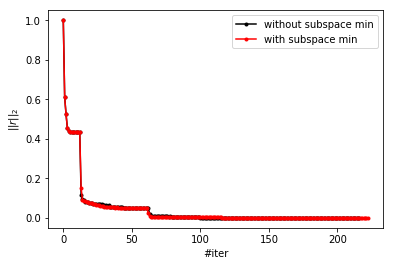

In [15]:
# Create random m-by-n encoding matrix and sparse vector
np.random.seed(0)

m = 50
n = 128
k = 14
[A, Rtmp] = np.linalg.qr(np.random.randn(n,m),'reduced')
A = A.T
p = np.random.permutation(n)
p = p[0:k]
x0 = np.zeros(n)
x0[p] = np.random.randn(k)

# Basis pursuit with subspace minimization
b = A.dot(x0) # signal
x,resid,grad,info = spg_bp(A, b, subspace_min=False, verbosity=2)
x,resid,grad,info_sub = spg_bp(A, b, subspace_min=True, verbosity=2)

plt.figure()
plt.plot(np.arange(info['niters']), info['rnorm2']/max(info['rnorm2']), '.-k', 
         label='without subspace min')
plt.plot(np.arange(info_sub['niters']), info_sub['rnorm2']/max(info_sub['rnorm2']), '.-r', 
         label='with subspace min')
plt.xlabel(r'#iter')
plt.ylabel(r'$||r||_2$')
plt.legend();